# Failed Banks Information Assistant

## Objective

This notebook demonstrates the following:

- Using Assistant tools Code Interpreter and Function calling, this bot can get a CSV file, gather a list of failed banks by state, and generate a chart to visually represent the data.

This tutorial uses the following Azure AI services:
- Access to Azure OpenAI Service - you can apply for access [here](https://aka.ms/oai/access)
- Azure OpenAI service - you can create it from instructions [here](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/create-resource)
- Azure OpenAI Studio - go to [https://oai.azure.com/](https://oai.azure.com/) to work with the Assistants API Playground
- A connection to the Azure OpenAI Service with a [Key and Endpoint](https://learn.microsoft.com/en-us/azure/ai-services/openai/chatgpt-quickstart)

Reference:
- Learn more about how to use Assistants with our [How-to guide on Assistants](https://learn.microsoft.com/en-us/azure/ai-services/openai/how-to/assistant).
- [Assistants OpenAI Overview](https://platform.openai.com/docs/assistants/overview)


## Time

You should expect to spend 5-10 minutes running this sample. 

## About this example

This sample demonstrates the creation of an Azure OpenAI Assistant named "Failed Banks Assistant" through the Azure OpenAI API. The assistant is tailored to aid users in retrieving information about failed banks from a CSV file, the assistant efficiently processes user messages, interacts with the designated file, and promptly delivers pertinent information in response.

### Data
This sample uses files from the folder [`data/`](./data/) in this repo. You can clone this repo or copy this folder to make sure you have access to these files when running the sample.

### Parameters

In [15]:
import os

from dotenv import load_dotenv

load_dotenv()

api_endpoint = os.getenv("OPENAI_URI")
api_key = os.getenv("OPENAI_KEY")
api_version = os.getenv("OPENAI_VERSION")
api_deployment_name = os.getenv("OPENAI_GPT_DEPLOYMENT")
email_URI = os.getenv("EMAIL_URI")

should_cleanup: bool = False

## Run this Example

### Load the required libraries

In [2]:
import io
import time
from datetime import datetime
from pathlib import Path
from typing import Iterable
 
from PIL import Image
import matplotlib.pyplot as plt

from openai import AzureOpenAI
from openai.types import FileObject
from openai.types.beta.threads.message_content_image_file import MessageContentImageFile
from openai.types.beta.threads.message_content_text import MessageContentText
from openai.types.beta.threads.messages import MessageFile
from PIL import Image

### Create an AzureOpenAI client

In [3]:
client = AzureOpenAI(api_key=api_key, api_version=api_version, azure_endpoint=api_endpoint)

### Prepare the tools for function calling

In [4]:
tools_list = [
    {"type": "code_interpreter"},
]

In [5]:
import os
from pathlib import Path 

DATA_FOLDER = "data/"
TARGET_FILE = "failed_banks.csv"

def upload_file(client: AzureOpenAI, path: str) -> FileObject:
    with Path(path).open("rb") as f:
        return client.files.create(file=f, purpose="assistants")

# 파일명으로 검색하여 파일이 존재하는지 확인
filePath = os.path.join(DATA_FOLDER, TARGET_FILE)
assistant_files = []

if os.path.exists(filePath):
    assistant_files.append(upload_file(client, filePath))

file_ids = [file.id for file in assistant_files]

print(file_ids)


['assistant-H2F2C7By2Y2qiizBYj325jNx']


In [7]:
assistant = client.beta.assistants.create(
    name="Failed Banks Assistant",
    instructions="You are an assistant that can help find information about failed banks. "
    + "Use the provided file only.",
    tools=tools_list,
    model=api_deployment_name,
    file_ids=file_ids,
)

thread = client.beta.threads.create()

In [8]:
def format_messages(messages: Iterable[MessageFile]) -> None:
    message_list = []

    # Get all the messages till the last user message
    for message in messages:
        message_list.append(message)
        if message.role == "user":
            break

    # Reverse the messages to show the last user message first
    message_list.reverse()

    # Print the user or Assistant messages or images
    for message in message_list:
        for item in message.content:
            # Determine the content type
            if isinstance(item, MessageContentText):
                print(f"{message.role}:\n{item.text.value}\n")
            elif isinstance(item, MessageContentImageFile):
                # Retrieve image from file id
                response_content = client.files.content(item.image_file.file_id)
                data_in_bytes = response_content.read()
                # Convert bytes to image
                readable_buffer = io.BytesIO(data_in_bytes)
                image = Image.open(readable_buffer)
                # Resize image to fit in terminal
                width, height = image.size
                image = image.resize((width // 2, height // 2), Image.LANCZOS)
                # Display image using matplotlib
                plt.imshow(image)
                plt.axis('off')  # Hide axis
                plt.show()


In [9]:
def process_message(content: str) -> None:
    client.beta.threads.messages.create(thread_id=thread.id, role="user", content=content)

    run = client.beta.threads.runs.create(
        thread_id=thread.id,
        assistant_id=assistant.id,
        instructions="The current date and time is: " + datetime.now().strftime("%x %X") + ".",
    )

    print("processing...")
    while True:
        run = client.beta.threads.runs.retrieve(thread_id=thread.id, run_id=run.id)
        if run.status == "completed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            break
        if run.status == "failed":
            messages = client.beta.threads.messages.list(thread_id=thread.id)
            format_messages(messages)
            # Handle failed
            break
        if run.status == "expired":
            # Handle expired
            break
        if run.status == "cancelled":
            # Handle cancelled
            break
        if run.status == "requires_action":
            pass
        else:
            # print("in progress...",run.status)
            time.sleep(5)

### Process user requests

processing...
user:
Create a chart of failed banks by state.

assistant:
To create a chart of failed banks by state, we will first need to read and examine the data provided in the uploaded file. Let's start by loading the file and inspecting its contents to understand its structure.

assistant:
It seems the file format could not be determined automatically. This can occur if the file is not a standard Excel file, such as if it's a CSV file. Let's inspect the file using a different method to determine its structure.

assistant:
The file type could not be determined via mimetypes. Let's read the first few bytes of the file to identify its format and structure manually.

assistant:
The first few bytes of the file indicate that it is a CSV file, rather than an Excel file. Let's load it as a CSV and then proceed with creating the chart of failed banks by state.

assistant:
The file has been successfully loaded, and it contains various columns including `Bank Name`, `City`, `State`, `Cert`,

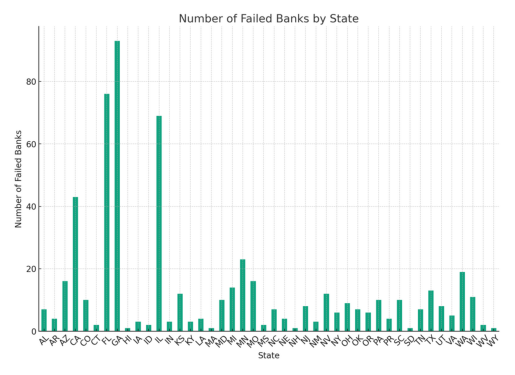

assistant:
Here's the chart showing the number of failed banks by state. If you have any further analysis or modifications you'd like to perform, please let me know.



In [10]:
process_message("Create a chart of failed banks by state.")

In [11]:
process_message("What was the last bank to fail?")

processing...
user:
What was the last bank to fail?

assistant:
To determine the last bank to fail, we need to identify the most recent closing date in the dataset and the corresponding bank. Let's find that information.

assistant:
The most recent bank to fail was "Citizens Bank" located in Sac City, IA. The closing date was November 3, 2023.

If you have any further questions or need additional analysis, please let me know!



In [12]:
process_message("Which state has the most bank failures?")

processing...
user:
Which state has the most bank failures?

assistant:
To determine which state has the most bank failures, we will identify the state with the highest count of failed banks. Let's find this information.

assistant:
The state with the most bank failures is Georgia (GA), with a total of 93 failed banks.

If you need any more information or further analysis, please let me know!



In [13]:
process_message("Which banks failed in Florida in between 2020-2023?")

processing...
user:
Which banks failed in Florida in between 2020-2023?

assistant:
To identify the banks in Florida that failed between 2020 and 2023, we will filter the dataset based on the `State` column for Florida (FL) and the `Closing Date` for the specified range. Let's perform this analysis.

assistant:
The bank in Florida that failed between 2020 and 2023 is:

- **Bank Name**: First City Bank of Florida
- **City**: Fort Walton Beach
- **Closing Date**: October 16, 2020

If you need any additional information or analysis, please let me know!



## Cleaning up


In [16]:
if should_cleanup:
    client.beta.assistants.delete(assistant.id)
    client.beta.threads.delete(thread.id)
    for file in assistant_files:
        client.files.delete(file.id)